In [284]:
import pytz
import time
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
import optuna
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [338]:
df = pd.read_csv('cleandata.csv')

In [294]:
df.head()

,time,latitude,longitude,depth,magnitude,magnitude_type,seismic_stations,gap,seismic_wave_residual,net,...,magError,magNst,status,locationSource,magSource,month,week,day_of_month,year,part_of_day
0,2001-01-02 10:53:23.280000+00:00,37.218,138.431,33.0,4.9,mb,43.0,104.29513,0.93,us,...,0.0,15.0,reviewed,us,us,January,Tuesday,2,2001,morning (6am-12pm)
1,2001-01-02 20:29:49.670000+00:00,32.239,141.508,33.0,4.9,mb,32.0,104.29513,0.96,us,...,0.0,23.0,reviewed,us,us,January,Tuesday,2,2001,evening (5pm-11pm)
2,2001-01-03 09:32:54.710000+00:00,45.301,149.941,33.0,4.6,mb,40.0,104.29513,0.82,us,...,0.0,20.0,reviewed,us,us,January,Wednesday,3,2001,morning (6am-12pm)
3,2001-01-03 14:47:49.540000+00:00,43.932,147.813,33.0,5.9,mwc,362.0,104.29513,0.82,us,...,0.0,0.0,reviewed,us,hrv,January,Wednesday,3,2001,afternoon (12pm-5pm)
4,2001-01-04 04:18:21.430000+00:00,36.981,138.629,21.4,5.3,mwc,240.0,104.29513,0.78,us,...,0.0,0.0,reviewed,us,hrv,January,Thursday,4,2001,early morning (2am-6am)


In [339]:
#sort values by time in ascending order
df.sort_values(by='time',inplace=True)

#set the time column as the index
df.set_index('time',inplace=True)

In [340]:
df.magnitude_type.unique()

array(['mb', 'mwc', 'ms', 'mwb', 'mwr', 'm', 'mw', 'mww'], dtype=object)

# Training-modeling

### 1. Forecasting using ARIMA model.

**Stationarity check**<br>ARIMA model requires the data to be stationary. So the block below performs the check and converts the non-stationary data to stationary.

In [13]:
# Function to check for stationarity and perform differencing if necessary
def make_stationary(data):
    result = adfuller(data)
    p_value = result[1]
    if p_value > 0.05:  # Data is non-stationary
        print("Data is non-stationary. Performing differencing...")
        return data.diff().dropna()  # Perform first-order differencing
    else:  # Data is stationary
        return data

# Make the data stationary
stationary_data = make_stationary(df['magnitude'])

We'll find the optimum order for the ARIMA model by training on small portion of the data.<br>
Let's take 7% data for training and testing purpose.

In [32]:
df2 = df[:1000]

# Splitting data into training and testing sets
train_size = int(len(df2) * 0.8)
train, test = df2[:train_size], df2[train_size:]
print(train_size, train.shape, test.shape)

800 (800, 21) (200, 21)


Now, time to run the block to find the optimum order.

In [16]:
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Function to evaluate ARIMA model
def evaluate_arima_model(data, order):
    train, test = data[:train_size], data[train_size:]
    history = [x for x in train['magnitude']]
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test['magnitude'][t])

    mse = mean_squared_error(test['magnitude'], predictions)
    return mse

# Find the best ARIMA model hyperparameters (p, d, q)
best_mse = float('inf')
best_order = None

for p in range(3):
    for d in range(3):
        for q in range(3):
            order = (p, d, q)
            try:
                mse = evaluate_arima_model(df2, order)
                if mse < best_mse:
                    best_mse = mse
                    best_order = order
            except:
                continue

completition_time = time.time()
elapsed_time = (completition_time - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

print('best_order:',best_order)

Started at:  17:24:28
Elapsed time: 23.91 minutes
best_order: (1, 2, 2)


In [28]:
# Train the final ARIMA model with the best hyperparameters
# best_order= (2,0,2)
model = ARIMA(df1['magnitude'], order=best_order)
model_fit = model.fit()

# Forecast future earthquakes
forecast_steps = 90  # Change this based on how many steps you want to forecast
forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean

# Print the forecasted magnitudes
print("Forecasted magnitudes:")
print(forecast)

Forecasted magnitudes:
14092    4.787595
14093    4.783094
14094    4.782926
14095    4.782932
14096    4.782945
           ...   
14177    4.784021
14178    4.784034
14179    4.784048
14180    4.784061
14181    4.784074
Name: predicted_mean, Length: 90, dtype: float64


In [20]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              magnitude   No. Observations:                14092
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -5872.205
Date:                Thu, 27 Jul 2023   AIC                          11752.410
Time:                        17:49:18   BIC                          11782.623
Sample:                             0   HQIC                         11762.465
                              - 14092                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0401      0.008      5.027      0.000       0.024       0.056
ma.L1         -1.9678      0.002  -1144.249      0.000      -1.971      -1.964
ma.L2          0.9678      0.002    561.665      0.000       0.964       0.971
sigma2         0.1347      0.001    202.495      0.000       0.133       0.136
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             69797.77
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's visualize the forcasted magnitudes.

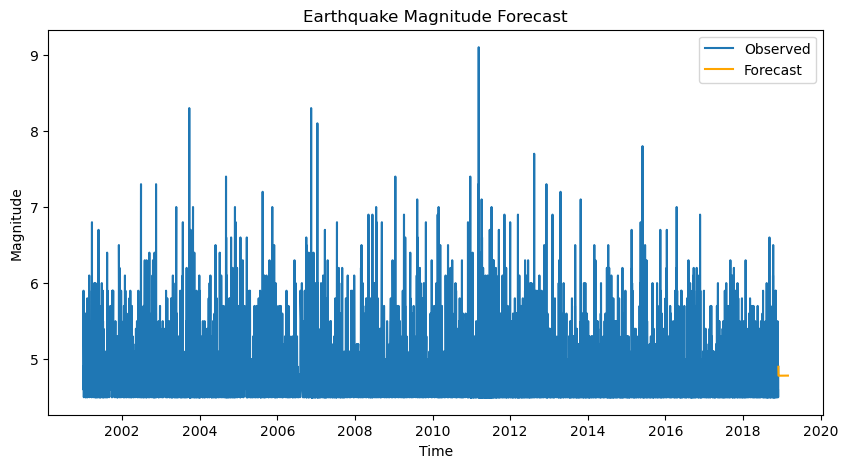

In [29]:
# Plot the forecasted values
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['magnitude'], label='Observed')

# Convert the DataFrame index to UTC
df.index = df.index.tz_convert('UTC')

# Set timezone to UTC for forecast_dates
utc = pytz.UTC
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, closed='right').tz_convert(utc)

# Adjust the forecast list to match the length of forecast_dates
adjusted_forecast = [df['magnitude'].iloc[-1]] + list(forecast)

# Add one more element to forecast_dates to match the length of adjusted_forecast
forecast_dates = forecast_dates.union(pd.DatetimeIndex([forecast_dates[-1] + forecast_dates.freq]))

# Plot the forecasted magnitudes using adjusted_forecast
plt.plot(forecast_dates, adjusted_forecast, label='Forecast', color='orange')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Earthquake Magnitude Forecast')
plt.show()

## 2. Using regression models: XGBoost & CatBoost 

## 2.1 XGBoost regression

**Encode the categorical data before training using OneHotEncoder()**

In [298]:
categorical_column = df['magnitude_type']
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder to your data to identify unique categories
encoder.fit(df[['magnitude_type']])

# Transform the data to one-hot encoded format
encoded_data = encoder.transform(df[['magnitude_type']])

# Get the column names for the encoded features
feature_names = encoder.get_feature_names_out(input_features=['magnitude_type'])

# Convert the encoded data to a pandas DataFrame with column names
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=feature_names)

In [299]:
encoded_df.head()

,magnitude_type_m,magnitude_type_mb,magnitude_type_ms,magnitude_type_mw,magnitude_type_mwb,magnitude_type_mwc,magnitude_type_mwr,magnitude_type_mww
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Check for collinearity.**

In [256]:
eigenvalues = np.linalg.eig(encoded_df.corr())
eigenvalues

(array([1.99840144e-15, 1.84848346e+00, 1.08200431e+00, 1.04152782e+00,
        1.02438244e+00, 1.00210886e+00, 1.00141056e+00, 1.00008254e+00]),
 array([[ 6.04522297e-02,  4.67259372e-02, -3.21229335e-02,
         -3.15127015e-02,  3.18282971e-02, -6.04846715e-01,
         -7.89749293e-01,  3.97586087e-02],
        [ 6.76912204e-01, -7.34763143e-01,  3.77593947e-02,
          1.82454135e-02, -1.05141744e-02,  6.54199895e-03,
          6.80523003e-04,  7.17997348e-04],
        [ 6.35498177e-02,  4.91354234e-02, -3.38334256e-02,
         -3.32499158e-02,  3.36720191e-02, -7.82760756e-01,
          6.13217960e-01,  3.75819090e-02],
        [ 1.38775592e-02,  1.06966648e-02, -7.24981937e-03,
         -7.00196924e-03,  6.91330596e-03, -5.16311464e-02,
         -8.17211056e-03, -9.98404254e-01],
        [ 2.34678416e-01,  1.89409861e-01, -1.68572428e-01,
         -2.46083434e-01,  9.00444189e-01,  9.53691141e-02,
          9.57169970e-03,  9.46591938e-03],
        [ 5.05837804e-01,  5.05998

Value 1.99840144e-15 is nearly close to 0, let's remove the column magnitude_type_m to avoid collinearity and dummy variable trap.

In [300]:
encoded_df.drop('magnitude_type_m',axis=1,inplace=True)

In [301]:
#before merging the encoded dataframe merge the categorical column from  original dataframe
df_no_magnitude_type = df.drop('magnitude_type',axis=1)
df_no_magnitude_type.reset_index(inplace=True)
df_no_magnitude_type = pd.concat([df_no_magnitude_type, encoded_df], axis=1)

In [302]:
df_no_magnitude_type['time'] = pd.to_datetime(df_no_magnitude_type['time'])
df_no_magnitude_type.set_index('time',inplace=True)

In [303]:
df_no_magnitude_type.head()

,index,latitude,longitude,depth,magnitude,seismic_stations,gap,seismic_wave_residual,net,id,...,day_of_month,year,part_of_day,magnitude_type_mb,magnitude_type_ms,magnitude_type_mw,magnitude_type_mwb,magnitude_type_mwc,magnitude_type_mwr,magnitude_type_mww
time,,,,,,,,,,,,,,,,,,,,,
2001-01-02 10:53:23.280000+00:00,0,37.218,138.431,33.0,4.9,43.0,104.29513,0.93,us,usp000a72e,...,2,2001,morning (6am-12pm),1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-02 20:29:49.670000+00:00,1,32.239,141.508,33.0,4.9,32.0,104.29513,0.96,us,usp000a72u,...,2,2001,evening (5pm-11pm),1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03 09:32:54.710000+00:00,2,45.301,149.941,33.0,4.6,40.0,104.29513,0.82,us,usp000a73h,...,3,2001,morning (6am-12pm),1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03 14:47:49.540000+00:00,3,43.932,147.813,33.0,5.9,362.0,104.29513,0.82,us,usp000a73r,...,3,2001,afternoon (12pm-5pm),0.0,0.0,0.0,0.0,1.0,0.0,0.0
2001-01-04 04:18:21.430000+00:00,4,36.981,138.629,21.4,5.3,240.0,104.29513,0.78,us,usp000a74c,...,4,2001,early morning (2am-6am),0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [304]:
df_xgb = df_no_magnitude_type[['magnitude','latitude','longitude','depth', 'seismic_stations', 'gap', 'seismic_wave_residual', 'magnitude_type_mb', 'magnitude_type_ms', 'magnitude_type_mw', 'magnitude_type_mwb',
       'magnitude_type_mwc', 'magnitude_type_mwr', 'magnitude_type_mww']]

In [305]:
df2 = df_xgb[:13000]
df2.head()

,magnitude,latitude,longitude,depth,seismic_stations,gap,seismic_wave_residual,magnitude_type_mb,magnitude_type_ms,magnitude_type_mw,magnitude_type_mwb,magnitude_type_mwc,magnitude_type_mwr,magnitude_type_mww
time,,,,,,,,,,,,,,
2001-01-02 10:53:23.280000+00:00,4.9,37.218,138.431,33.0,43.0,104.29513,0.93,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-02 20:29:49.670000+00:00,4.9,32.239,141.508,33.0,32.0,104.29513,0.96,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03 09:32:54.710000+00:00,4.6,45.301,149.941,33.0,40.0,104.29513,0.82,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03 14:47:49.540000+00:00,5.9,43.932,147.813,33.0,362.0,104.29513,0.82,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2001-01-04 04:18:21.430000+00:00,5.3,36.981,138.629,21.4,240.0,104.29513,0.78,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Hyperparameter tuning with Optuna

In [306]:
data = df2
# Define the objective function for Optuna to optimize with walk-forward validation
def objective(trial):
    search_space = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }
    # Define the sub-sample size (adjust this according to your preference)
    sub_sample_size = 0.5  # 50% of the data

    # Create a random sub-sample of the data
    sub_sampled_data = data.sample(frac=sub_sample_size, random_state=42)

    # Split the sub-sampled data into features and target
    X = sub_sampled_data.drop(columns=["magnitude"])
    y = sub_sampled_data["magnitude"]
    
    # Create a rolling window or walk-forward split using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=10)  # You can adjust the number of splits as needed
    split_indices = tscv.split(X)
    
    # Initialize a list to store the mean squared errors for each step
    mse_list = []

    # Iterate over each step and train and validate the model
    for train_idx, val_idx in split_indices:
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Create and train the XGBoost model with the current hyperparameters
        model = xgb.XGBRegressor(**search_space)
        model.fit(X_train, y_train)

        # Make predictions on the validation data
        y_pred = model.predict(X_val)

        # Calculate the mean squared error for this step
        mse = ((y_val - y_pred) ** 2).mean()
        mse_list.append(mse)

    # Return the average mean squared error across all steps as the objective to minimize
    return np.mean(mse_list)

# Run the Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Get the best hyperparameters from the study
best_params = study.best_params
print(best_params)

[I 2023-08-01 19:32:41,158] A new study created in memory with name: no-name-10cab5f8-dd23-482a-893a-724caeaad77a
[I 2023-08-01 19:32:47,225] Trial 0 finished with value: 0.0867905547403856 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.011366690683031321, 'subsample': 0.8493567296605511, 'colsample_bytree': 0.8653283288756393}. Best is trial 0 with value: 0.0867905547403856.
[I 2023-08-01 19:32:50,579] Trial 1 finished with value: 0.059364443362459385 and parameters: {'n_estimators': 176, 'max_depth': 9, 'learning_rate': 0.020262669208917432, 'subsample': 0.5327660465500994, 'colsample_bytree': 0.5640740614718207}. Best is trial 1 with value: 0.059364443362459385.
[I 2023-08-01 19:32:58,124] Trial 2 finished with value: 0.042965282683875776 and parameters: {'n_estimators': 265, 'max_depth': 9, 'learning_rate': 0.027981311076448728, 'subsample': 0.707835966878601, 'colsample_bytree': 0.9964215032616354}. Best is trial 2 with value: 0.042965282683875776.
[I 202

{'n_estimators': 253, 'max_depth': 6, 'learning_rate': 0.029866179163351124, 'subsample': 0.7421964730545106, 'colsample_bytree': 0.621791059030317}


**Best parameters**

In [307]:
best_params2 = {'n_estimators': 253, 'max_depth': 6, 'learning_rate': 0.029866179163351124, 'subsample': 0.7421964730545106, 'colsample_bytree': 0.621791059030317}

**Perform the rmse test on the training data.**

In [346]:
X = df2.drop(columns=["magnitude"])
y = df2["magnitude"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [347]:
# Create and train the XGBoost model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params2)
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the best model's performance (Root Mean Squared Error, RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Model RMSE: {rmse}")

Best Model RMSE: 0.20952378940647617


**Perform the rmse test on testing data.**

In [311]:
X_test1 = df_xgb.drop(columns=['magnitude'])[13000:]
y_test1 = df_xgb.magnitude[13000:]

# Make predictions on the test data
y_pred1 = best_model.predict(X_test1)

# Evaluate the best model's performance (Root Mean Squared Error, RMSE)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print(f"Best Model RMSE: {rmse}")

Best Model RMSE: 0.21007151897723947


**Merge the predicted data to the original dataframe.**

In [405]:
df3 = df_xgb[13000:]
df3.reset_index(inplace=True)

In [406]:
mag = pd.DataFrame({'predicted_mag': y_pred1.round(1)})
df4 = pd.concat([mag,df3], axis=1)
df4.set_index('time',inplace=True)

In [407]:
df4.head()

,predicted_mag,magnitude,latitude,longitude,depth,seismic_stations,gap,seismic_wave_residual,magnitude_type_mb,magnitude_type_ms,magnitude_type_mw,magnitude_type_mwb,magnitude_type_mwc,magnitude_type_mwr,magnitude_type_mww
time,,,,,,,,,,,,,,,
2016-12-31 21:08:02.160000+00:00,4.7,4.8,26.0580,128.7113,8.26,1.0,77.0,0.54,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02 16:10:59.130000+00:00,4.7,4.6,38.8698,142.8242,35.00,1.0,112.0,1.42,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02 18:35:22.930000+00:00,4.6,4.5,34.0275,136.4244,376.64,1.0,73.0,0.69,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02 21:24:20.610000+00:00,4.6,4.5,41.2084,142.0005,55.03,1.0,127.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03 04:38:38.750000+00:00,4.7,4.8,30.5247,131.1366,32.13,1.0,102.0,0.68,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Create a time series plot.**

In [401]:
y1 = df4.magnitude
y1 = y1.resample('D').median() 
y1 = y1.fillna(y1.mean())

y2 = df4.predicted_mag
y2 = y2.resample('D').median() 
y2 = y2.fillna(y2.mean())

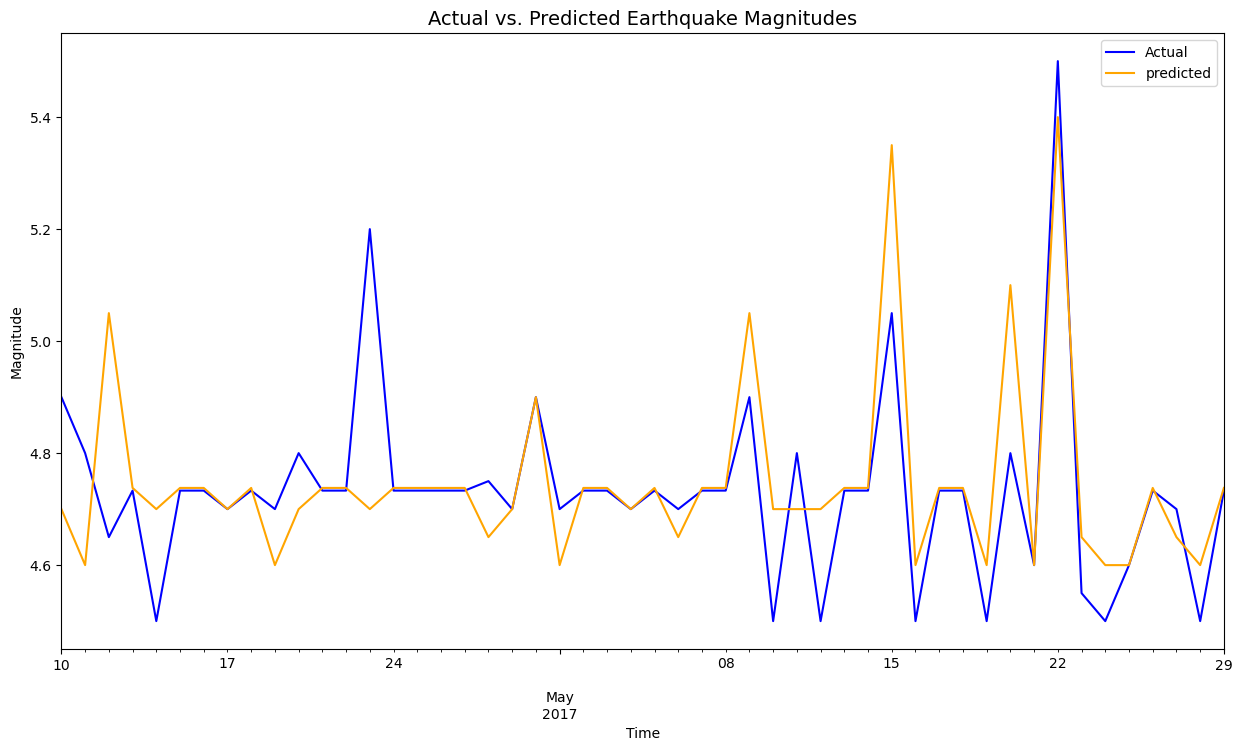

In [317]:
plt.figure(figsize=(15,8))
y1[100:150].plot(color='blue',label='Actual')
y2[100:150].plot(color='orange',label='predicted')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Actual vs. Predicted Earthquake Magnitudes', fontsize=14)
plt.legend()
plt.show()

**Find the features with importance.**

In [318]:
# take a look at feature importance
imp = pd.Series(best_model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

magnitude_type_mwr       0.185502
seismic_stations         0.180767
magnitude_type_mb        0.180623
magnitude_type_mww       0.162167
magnitude_type_mwc       0.104438
magnitude_type_mwb       0.076505
gap                      0.061116
seismic_wave_residual    0.017046
depth                    0.010556
longitude                0.007365
latitude                 0.007004
magnitude_type_ms        0.006913
magnitude_type_mw        0.000000
dtype: float32


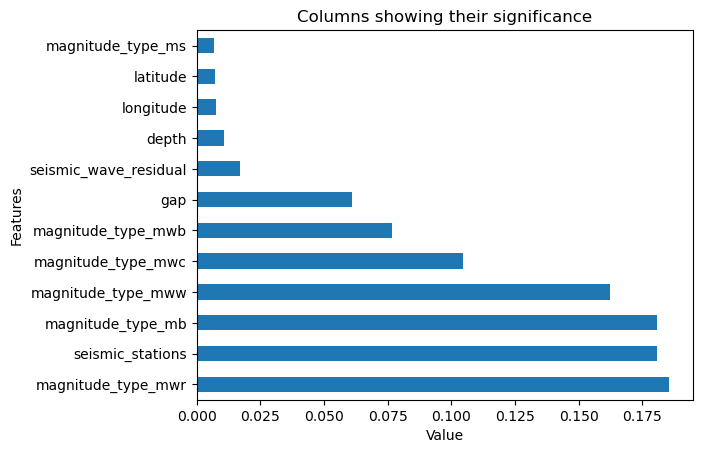

In [327]:
imp.nlargest(12).plot(kind='barh')
plt.title('Columns showing their significance')
plt.xlabel('Value')
plt.ylabel("Features")
plt.show()

Column magnitude_type_mwr has high impact on the prediction of magnitude followed by magnitude_type_mb and seismic_stations.

## 2.2 CatBoost regression

In [350]:
df_cb = df[['magnitude','latitude','longitude','depth', 'seismic_stations', 'gap', 'seismic_wave_residual', 'magnitude_type']]
df1 = df_cb[:13000]

### Hyperparameter tuning with Optuna

In [343]:
# Define the target and features
target_column = 'magnitude'
categorical_features = ['magnitude_type']
numerical_features = ['latitude', 'longitude', 'depth','seismic_stations', 'gap', 'seismic_wave_residual']

# Separate target column from features
X = df1[numerical_features + categorical_features]
y = df1[target_column]

# Split the data into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a sub-sample of the data
sub_sample_size = 3000  # Adjust the size of the sub-sample as needed
random_indices = np.random.choice(X_train_full.index, sub_sample_size, replace=False)
X_train = X_train_full.loc[random_indices]
y_train = y_train_full.loc[random_indices]

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        # Add more hyperparameters to tune as needed
    }

    # Initialize the CatBoostRegressor model with the current hyperparameters
    model = CatBoostRegressor(
        loss_function='RMSE',
        cat_features=categorical_features,
        random_state=42,
        verbose=100,
        **params
    )

    # Perform cross-validation using cross_val_score
    cv_scores = -cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,  # You can adjust the number of folds as needed
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Get the mean RMSE across all cross-validation folds
    mean_rmse = np.sqrt(cv_scores.mean())

    return mean_rmse

# Run the Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Get the best hyperparameters from the study
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-08-01 20:04:09,711] A new study created in memory with name: no-name-74c0b02c-39b2-461c-a923-02f5e97b9004
[I 2023-08-01 20:05:09,378] Trial 0 finished with value: 0.21863886464617036 and parameters: {'iterations': 565, 'learning_rate': 0.2493920533514998, 'depth': 10}. Best is trial 0 with value: 0.21863886464617036.
[I 2023-08-01 20:05:23,512] Trial 1 finished with value: 0.22182524755381489 and parameters: {'iterations': 308, 'learning_rate': 0.42770245606215185, 'depth': 6}. Best is trial 0 with value: 0.21863886464617036.
[I 2023-08-01 20:05:58,623] Trial 2 finished with value: 0.2141320648983192 and parameters: {'iterations': 355, 'learning_rate': 0.010881318632651075, 'depth': 10}. Best is trial 2 with value: 0.2141320648983192.
[I 2023-08-01 20:06:07,507] Trial 3 finished with value: 0.22138338808438285 and parameters: {'iterations': 198, 'learning_rate': 0.4863450059476638, 'depth': 7}. Best is trial 2 with value: 0.2141320648983192.
[I 2023-08-01 20:06:31,069] Trial 4 

Best Hyperparameters: {'iterations': 900, 'learning_rate': 0.016691198262196054, 'depth': 6}


**Best parameters.**

In [348]:
best_params2 = {'iterations': 900, 'learning_rate': 0.016691198262196054, 'depth': 6}

**Perform the rmse test on training data.**

In [352]:
# Train the best model on the full training data
best_model = CatBoostRegressor(
    loss_function='RMSE',
    cat_features=categorical_features,
    random_state=42,
    verbose=100,
    **best_params2
)
best_model.fit(X_train_full, y_train_full)

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model's performance (Root Mean Squared Error, RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Model RMSE: {rmse}")

0:	learn: 0.3777573	total: 27.2ms	remaining: 24.5s
100:	learn: 0.2228378	total: 2.44s	remaining: 19.3s
200:	learn: 0.2030082	total: 4.95s	remaining: 17.2s
300:	learn: 0.1966623	total: 7.34s	remaining: 14.6s
400:	learn: 0.1925467	total: 9.65s	remaining: 12s
500:	learn: 0.1894650	total: 12s	remaining: 9.59s
600:	learn: 0.1867075	total: 14.4s	remaining: 7.15s
700:	learn: 0.1841132	total: 16.7s	remaining: 4.73s
800:	learn: 0.1818625	total: 19.1s	remaining: 2.36s
899:	learn: 0.1798034	total: 21.5s	remaining: 0us
Best Model RMSE: 0.20830321884744382


**Perform the rmse test on testing data.**

In [359]:
X_test1 = df_cb.drop(columns=['magnitude'])[13000:]
y_test1 = df_cb.magnitude[13000:]

# Make predictions on the test data
y_pred1 = best_model.predict(X_test1)

# Evaluate the best model's performance (Root Mean Squared Error, RMSE)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print(f"Best Model RMSE: {rmse}")

Best Model RMSE: 0.21002558933347357


**Merge the predicted data to the original dataframe.**

In [408]:
df3 = df_cb[13000:]
df3.reset_index(inplace=True)

In [411]:
mag = pd.DataFrame({'predicted_mag': y_pred1.round(1)})
df4 = pd.concat([mag,df3], axis=1)
df4.set_index('time',inplace=True)
df4.index = pd.to_datetime(df4.index)

In [412]:
y1 = df4.magnitude
y1 = y1.resample('D').median() 
y1 = y1.fillna(y1.mean())

y2 = df4.predicted_mag
y2 = y2.resample('D').median() 
y2 = y2.fillna(y2.mean())

In [413]:
df4.head()

,predicted_mag,magnitude,latitude,longitude,depth,seismic_stations,gap,seismic_wave_residual,magnitude_type
time,,,,,,,,,
2016-12-31 21:08:02.160000+00:00,4.7,4.8,26.0580,128.7113,8.26,1.0,77.0,0.54,mb
2017-01-02 16:10:59.130000+00:00,4.7,4.6,38.8698,142.8242,35.00,1.0,112.0,1.42,mb
2017-01-02 18:35:22.930000+00:00,4.6,4.5,34.0275,136.4244,376.64,1.0,73.0,0.69,mb
2017-01-02 21:24:20.610000+00:00,4.6,4.5,41.2084,142.0005,55.03,1.0,127.0,0.89,mwr
2017-01-03 04:38:38.750000+00:00,4.7,4.8,30.5247,131.1366,32.13,1.0,102.0,0.68,mb


**Create a time series plot.**

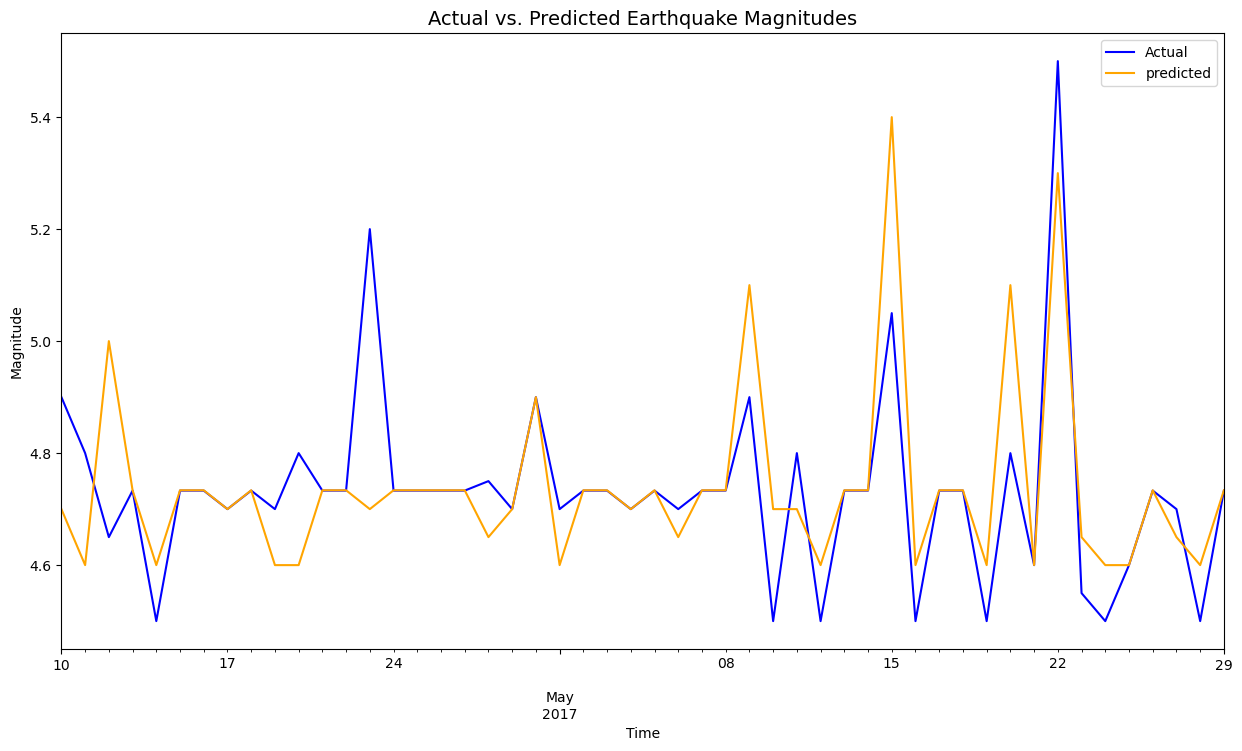

In [414]:
plt.figure(figsize=(15,8))
y1[100:150].plot(color='blue',label='Actual')
y2[100:150].plot(color='orange',label='predicted')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Actual vs. Predicted Earthquake Magnitudes', fontsize=14)
plt.legend()
plt.show()

**Find features with importance.**

In [415]:
# take a look at feature importance
imp = pd.Series(best_model.feature_importances_, index=X_test1.columns)
imp = imp.sort_values(ascending=False)
print(imp)

seismic_stations         37.741049
magnitude_type           23.790035
gap                      17.057082
seismic_wave_residual     7.959850
depth                     6.187063
longitude                 3.643116
latitude                  3.621806
dtype: float64


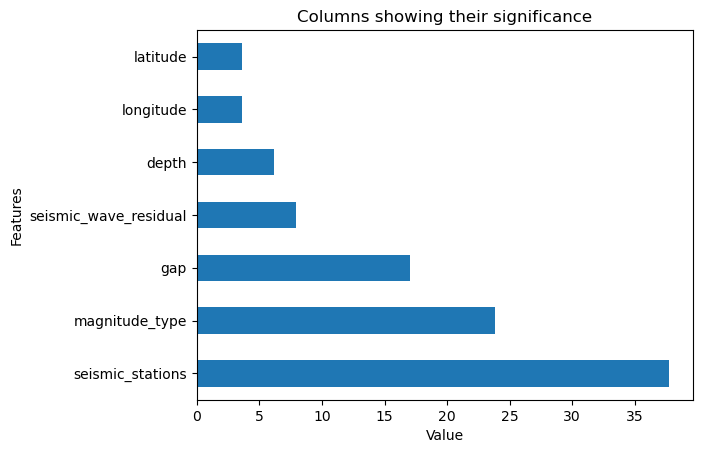

In [416]:
imp.nlargest(10).plot(kind='barh')
plt.title('Columns showing their significance')
plt.xlabel('Value')
plt.ylabel("Features")
plt.show()

Column seismic_stations and magnitude_type have high impact on the predition of magnitude.

# Evaluation

In [403]:
data = [{'CatBoost':0.208,'XGBoost':0.209}, {'CatBoost':0.210, 'XGBoost':0.210}]

rmse = pd.DataFrame(data,index=['Training','Testing'])
rmse

,CatBoost,XGBoost
Training,0.208,0.209
Testing,0.210,0.210


Looking at the plots and the RMSE scores, both CatBoost and XGBoost have almost similar performance. If we have to pick one between the two, CatBoost can be chosen as it is able to handle categorical data on its own, eliminating the need for label encoding.